# imports & init

In [1]:
import wandb
from dotenv import load_dotenv
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install einops
    !pip install https://github.com/neelnanda-io/TransformerLens@no-position-experiment
    !pip install transformer_lens
    !pip install wandb
    !pip install python-dotenv

    # for wandb logging, make a credentials file that looks like this:
    # $ cat drive/MyDrive/ML/credentials/credentials.env
    # WANDB_API_KEY=YOUR_KEY_HERE
    # WANDB_PROJECT=oocl
    # WANDB_ENTITY=asic_oocl

    assert load_dotenv(dotenv_path="drive/MyDrive/ML/credentials/credentials.env")
    wandb.login(key=os.getenv("WANDB_API_KEY"))
    dir_models = "drive/MyDrive/ML/models/transformers/"  # save models here
except:
    IN_COLAB = False
    assert load_dotenv()
    wandb.login(key=os.getenv("WANDB_API_KEY"))
    dir_models = "models/transformers/"  # save models here

from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch
import numpy as np
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "colab"
import tqdm.auto as tqdm
import einops
from transformer_lens.utils import to_numpy
import os
from datetime import datetime
import time
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

wandb: Currently logged in as: andrei-cristea (asic_oocl). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/andrei/.netrc
/home/andrei/.pyenv/versions/3.12.1/envs/mechint/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/andrei/.pyenv/versions/3.12.1/envs/mechint/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
os.environ["WANDB_MODE"] = "offline"

In [4]:
def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor, yaxis="", xaxis="", **kwargs):
    tensor = to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

# data generation & training info

In [5]:
def make_data_generator(cfg, n_groups, batch_size, seed=123):
    # the first group data looks like A, B and B, C with equal prob
    # other group data looks like A, B and B, C and C, A with equal prob

    torch.manual_seed(seed)
    while True:
        nb = batch_size
        ng = n_groups

        g_b = torch.randint(0, ng, (nb, )) # dim=[batch,]
        x_bc = torch.empty((nb, cfg.n_ctx), dtype=torch.long) # dim=[batch, n_ctx]
        # x_bc[:, 0] = g_b * size_group

        i_b = torch.rand((nb, ))

        # the first group data looks like A, B and B, C with equal prob
        x_bc[(g_b == 0) & (i_b <= 0.5), 0] = 0
        x_bc[(g_b == 0) & (i_b <= 0.5), 1] = 1
        x_bc[(g_b == 0) & (i_b >  0.5), 0] = 1
        x_bc[(g_b == 0) & (i_b >  0.5), 1] = 2

        # other group data looks like (A, B) and (B, C) and (C, A) with equal prob
        m_b = torch.randint(0, nm, (nb, )) # "relative" group member position
        i = g_b != 0
        x_bc[i, 0] = (g_b * nm + m_b)[i]
        x_bc[i, 1] = (g_b * nm + ((m_b + 1) % nm))[i]
        x_bc[i, 2] = cfg.d_vocab - 1  # the last token is the "end" token
        yield x_bc

# data_generator = make_data_generator(cfg, 16)
# print(next(data_generator))

In [6]:
def loss_fn(logits, tokens, per_token=False):
    # logit shape: [batch, pos, vocab]
    # token shape: [batch, pos]
    logits = logits[:, :-1]
    tokens = tokens[:, 1:]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if per_token:
        return -correct_log_probs
    else:
        return -correct_log_probs.mean()

# spec out and train the models

In [7]:
details = []

In [8]:
batch_size = 2**10
num_epochs = 100000
lr = 1e-4
betas = (0.9, 0.95)
max_grad_norm = 1.0
wd = 0.1

In [9]:
del tqdm
from tqdm.auto import tqdm

In [14]:
# n_layers_list = [2**i for i in range(1)]  # attempt oocl for bigger and bigger models
n_layers_list = [2]
n_groups = 10
size_group = 3  # e.g. A, B, C form a group
nm = size_group  # number of members in group
default_transformer_config = dict(
    d_model=2**6,
    d_head=2**6,
    n_heads=4,
    d_mlp=2**9,
    d_vocab=nm * n_groups + 1,  # +1 to include an end token
    n_ctx=3,
    act_fn="relu",
    normalization_type="LN",
)
cfgs = [
    HookedTransformerConfig(
        n_layers=n_layers,
        **default_transformer_config,
    ) for n_layers in n_layers_list
]
for i_cfg, cfg in enumerate(cfgs):
    ts_start_training = time.time()
    name = f"tiny_{cfg.n_layers:04}"
    wandb.init(
        # set the wandb project where this run will be logged
        project=os.getenv("WANDB_PROJECT"),
        entity=os.getenv("WANDB_ENTITY"),
        name=name,

        # track hyperparameters and run metadata
        config={
            "n_layers": cfg.n_layers,
            "n_groups": n_groups,
            "lr": lr,
            "wd": wd,
            "batch_size": batch_size,
            **default_transformer_config,
        }
    )
    print(f"n_layers={cfg.n_layers}")
    model = HookedTransformer(cfg)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=wd)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / 1000, 1.0))
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-1, step_size_up=num_epochs//4, last_epoch=-1, cycle_momentum=True)
    data_loader = make_data_generator(cfg, n_groups, batch_size)
    # losses, ranks = [], []
    with tqdm(total=num_epochs, position=0, leave=True) as pbar:
        for epoch in tqdm(range(num_epochs), position=i_cfg, leave=True):
            print(epoch, end=", ")
            tokens = next(data_loader)
            tokens = tokens.cuda()
            logits = model(tokens)
            loss = loss_fn(logits, tokens)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            # losses.append(loss.item())
            if epoch > 0 & epoch % 250 == 0:
                print(f"Epoch {epoch}: {loss.item():.5f}, lr: {scheduler.get_last_lr()[0]:.5f}", end=", ")
    
                # Test how the desired token stacks up
                model.eval()
                with torch.no_grad():
                    tokens = torch.tensor([[2, 1, cfg.d_vocab - 1]], dtype=torch.long, device=device)
                    logits = model(tokens)
                    probs = logits[0][0].softmax(dim=0)
                    rank = probs.argsort()[0].item()
                    # ranks.append(rank)
    
                    # details.append({
                    #     "step": epoch,
                    #     "n_layers": cfg.n_layers,
                    #     "loss": loss.item(),
                    #     "rank": rank,
                    #     "prob": probs[0].item(),
                    #     "n_groups": n_groups,
                    #     "ts": datetime.now(),
                    # })
                    prob_mult = probs[0].item() * n_groups * nm  # multiple of "naive prior"
                    print(f"ooc tgt rank: {rank}, ooc prob: {prob_mult:.2f}")
                    wandb.log({
                        "train_loss": loss.item(),
                        "target_rank": rank,
                        "target_prob_mult": prob_mult,
                    })
                model.train()
            pbar.update()
    ts_finish_training = time.time()
    wandb.finish()
    print(f"training n_layers={cfg.n_layers} took {(ts_finish_training - ts_start_training)//60} minutes")
    torch.save(model.state_dict(), os.path.join(dir_models, name))

target_prob_mult,▁
target_rank,▁
train_loss,▁
target_prob_mult,0.5276
target_rank,12
train_loss,3.46869


n_layers=2


  0%|                                                                                                                                                                                                                            | 0/100000 [00:00<?, ?it/s]

0, 

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [107,0,0], thread: [96,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [107,0,0], thread: [97,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [107,0,0], thread: [98,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [107,0,0], thread: [99,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [107,0,0], thread: [100,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [107,0,0], thread: [101,0,0] Assertio

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
from dataclasses import asdict

In [24]:
@dataclass
class Foo:
    fifo: int = 54
    fofum: str = "ismellanenglishman"

In [25]:
x = Foo()

In [26]:
asdict(x)

{'fifo': 54, 'fofum': 'ismellanenglishman'}

In [22]:
@dataclass
class Point:
     x: int
     y: int

p = Point(10, 20)
assert asdict(p) == {'x': 10, 'y': 20}

In [23]:
asdict(p)

{'x': 10, 'y': 20}

In [ ]:
model.train()

In [11]:
tokens

tensor([[2, 1]], device='cuda:0')

In [11]:
tokens = next(data_loader)
tokens = tokens.cuda()
logits = model(tokens)
loss = loss_fn(logits, tokens)
loss.backward()
if max_grad_norm is not None:
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

In [28]:
optimizer.step()

In [29]:
optimizer.zero_grad()

In [30]:
scheduler.step()

In [10]:
x = next(iter(data_loader))

In [11]:
x

tensor([[20, 18, 30],
        [29, 27, 30],
        [ 7,  8, 30],
        ...,
        [27, 28, 30],
        [14, 12, 30],
        [22, 23, 30]], device='cuda:0')

In [15]:
x.shape

torch.Size([1024, 3])

In [14]:
model(x).shape

torch.Size([1024, 3, 31])

In [ ]:
model.eval()
optimizer.zero_grad()
tokens = torch.tensor([[1, 1]], dtype=torch.long, device=device)
logits = model(tokens)
probs = logits[0][0].softmax(dim=0)
rank = probs.argsort()[0].item()

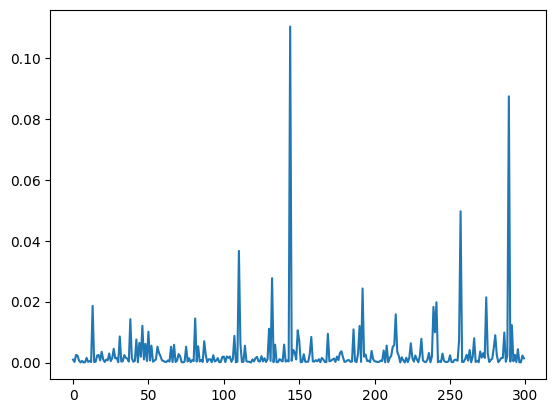

In [ ]:
plt.plot(probs.detach().cpu().numpy())

In [ ]:
details

[]

In [ ]:
tokens = next(data_loader)
logits = model(tokens)
loss = loss_fn(logits, tokens)

In [ ]:
tokens = torch.tensor([[2, 1]], dtype=torch.long, device=device)
logits = model(tokens)
print(logits.argmax(dim=2))
loss = loss_fn(logits, tokens).item()
print(loss)

tensor([[5, 2]], device='cuda:0')
3.707723379135132


In [ ]:
logits[0][0].softmax(dim=0)

tensor([1.1872e-02, 2.4533e-02, 1.5753e-03, 4.6441e-04, 3.0527e-02, 8.5076e-01,
        5.5864e-04, 3.2492e-02, 4.7218e-02], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
logits[0][0].softmax(dim=0).argsort()[0].item()

3

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
torch.save(model.state_dict(), os.path.join(dir_save_model, "no_pos_experiment_state_dict_v0.pth"))

In [1]:
from src.toy_model import *

/home/andrei/.pyenv/versions/3.12.1/envs/mechint/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:using device: cuda


In [2]:
data_params = DataParams()
transformer_config = default_transformer_config
transformer_config.update(dict(
    n_layers=2,
    d_vocab=data_params.n_groups * data_params.size_group + 1,
))
cfg = HookedTransformerConfig(**transformer_config)

model = HookedTransformer(cfg)

In [3]:
data_loader = make_data_generator_withending_noisy(cfg, 10, 3, 2**8)

In [4]:
data_params

DataParams(n_groups=1000, size_group=3)

In [5]:
next(data_loader)

tensor([[  18,   19, 3000],
        [  29,   27, 3000],
        [   6,    7, 3000],
        [  24,   14, 3000],
        [  16,   17, 3000],
        [  20,   18, 3000],
        [  26,   24, 3000],
        [   9,   10, 3000],
        [   9,   10, 3000],
        [   1,    2, 3000],
        [  21,   22, 3000],
        [  26,   24, 3000],
        [  25,   26, 3000],
        [  18,   19, 3000],
        [  23,   21, 3000],
        [  28,   29, 3000],
        [  17,   15, 3000],
        [  22,   23, 3000],
        [  25,   26, 3000],
        [   4,    5, 3000],
        [  22,   23, 3000],
        [  22,   23, 3000],
        [  20,   18, 3000],
        [   8,    6, 3000],
        [  12,   13, 3000],
        [  14,   12, 3000],
        [  24,   25, 3000],
        [  12,   13, 3000],
        [  26,   24, 3000],
        [  24,   25, 3000],
        [  29,   27, 3000],
        [   3,    4, 3000],
        [   3,    4, 3000],
        [  18,   19, 3000],
        [  15,   16, 3000],
        [  19,   20,